In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [43]:
import pandas_profiling

In [44]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

In [45]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [46]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [47]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [5]:
df=pd.read_csv('master.csv')

In [6]:
df.describe()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,16866.464414
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,3447.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,9372.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,24874.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,126352.000000


In [7]:
#country-year can be deleted, it doesn't contain any new information
#gdp_for_year should be a number not a string, and I don't want to type out that name
df.describe(exclude='number').T.sort_values('unique')

,count,unique,top,freq
sex,27820,2,female,13910
age,27820,6,25-34 years,4642
generation,27820,6,Generation X,6408
country,27820,101,Austria,382
country-year,27820,2321,Iceland1991,12
gdp_for_year ($),27820,2321,"173,537,588,008",12


In [8]:
#wrap up the cleaning into a simple function to run on the data 
def cleanUp(df):
    df['annual_gdp']=df[' gdp_for_year ($) '].str.replace(',','')
    
    df=df.drop([' gdp_for_year ($) ','country-year', 'suicides/100k pop', 'year'], axis=1)
    df['annual_gdp']=df['annual_gdp'].astype(int)
    
    countrySer=df.groupby('country')["HDI for year"].mean()
    def HDIcleanup(data):
        country=data[0]
        HDI=data[1]
        if np.isnan(HDI):       
            return countrySer[country]
        else:
            return HDI
    df['HDI_for_year']=df[['country','HDI for year']].apply(HDIcleanup,axis=1)
    df=df.drop('HDI for year', axis=1)
    df=df.dropna()
    y=df['suicides_no']
    df=df.drop('suicides_no',axis=1)
    return df, y

In [9]:
df, y=cleanUp(df)

In [10]:
X_train, X_test, y_train, y_test= train_test_split(df,y)

In [11]:
df.describe(exclude='number')

,country,sex,age,generation
count,26334,26334,26334,26334
unique,90,2,6,6
top,Austria,female,25-34 years,Generation X
freq,382,13167,4394,6062


In [12]:
#suicides/100k is a calculation based on suicides_no (which is the target)
#this is a regression problem
df.describe()

,population,gdp_per_capita ($),annual_gdp,HDI_for_year
count,2.633400e+04,26334.000000,2.633400e+04,26334.000000
mean,1.753087e+06,17017.479836,4.494139e+11,0.774271
std,3.804919e+06,19215.718811,1.488713e+12,0.087415
min,4.240000e+02,251.000000,1.456417e+08,0.483000
25%,9.930000e+04,3424.000000,9.024567e+09,0.707900
50%,4.325410e+05,9070.000000,4.641892e+10,0.779600
75%,1.414290e+06,25165.000000,2.506385e+11,0.853000
max,4.380521e+07,126352.000000,1.812071e+13,0.944000


In [14]:
#HDI for year needs to be addressed. I think I want to impute the missing values by taking the mean 
#of the country, and then dropping the countries that don't have an HDI. 
#thats going to require writing a function to take in all the information
df[df['HDI_for_year'].isna()].groupby('country')['annual_gdp'].mean()

Series([], Name: annual_gdp, dtype: int64)

In [15]:
df.head()

,country,sex,age,population,gdp_per_capita ($),generation,annual_gdp,HDI_for_year
0,Albania,male,15-24 years,312900,796,Generation X,2156624900,0.673
1,Albania,male,35-54 years,308000,796,Silent,2156624900,0.673
2,Albania,female,15-24 years,289700,796,Generation X,2156624900,0.673
3,Albania,male,75+ years,21800,796,G.I. Generation,2156624900,0.673
4,Albania,male,25-34 years,274300,796,Boomers,2156624900,0.673


In [16]:
#begin with mean baseline
y_train.mean()
y_pred=np.full_like(y_train, y_train.mean())
mean_absolute_error(y_train, y_pred)


267.35569620253165

In [17]:
pipe=make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    MinMaxScaler(),
    #SelectKBest(k=58),
    RandomForestRegressor(n_jobs=-1, n_estimators=100)
)

In [18]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['country', 'sex', 'age', 'generation'],
                               drop_invariant=False, handle_unknown='impute',
                               impute_missing=True, return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('minmaxscaler...
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                 

In [19]:
X_train.shape, y_train.shape, X_test.shape,y_test.shape

((19750, 8), (19750,), (6584, 8), (6584,))

In [21]:
#even using just those two metrics we are able to beat the mean baseline score
-cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()

20.400241518987343

In [ ]:
importance=pipe.named_steps['randomforestregressor'].feature_importances_

In [ ]:
cols=pipe.named_steps['onehotencoder'].transform(X_train[['population','HDI_for_year']]).columns
#cols=cols[pipe.named_steps['selectkbest'].get_support()].tolist()


In [ ]:
X_train.head()
#pipe.named_steps['onehotencoder'].transform(X_train)

In [ ]:
fig=plt.figure(figsize=(10,6))
pd.Series(index=cols, data=importance).sort_values().plot.barh()


In [28]:
import eli5
from eli5.sklearn import PermutationImportance

In [37]:
encoderpipe=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer()
)

X_train_encoded=encoderpipe.fit_transform(X_train)
model=RandomForestRegressor(n_estimators=100, n_jobs=-1)
model.fit(X_train_encoded, y_train)

permuter = PermutationImportance(
    model,
    scoring='neg_mean_absolute_error',
    n_iter=2
)

permuter.fit(X_train_encoded,y_train)

PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100,
                                                      n_jobs=-1,
                                                      oob_score=False,
   

In [38]:
features=X_train.columns.tolist()

In [40]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=features
)

Weight,Feature
221.8199 ± 0.0364,population
106.7190 ± 0.3100,sex
92.8763 ± 2.1240,age
81.0805 ± 1.3885,annual_gdp
63.7192 ± 1.3685,country
28.2540 ± 0.2442,HDI_for_year
12.3925 ± 0.1684,generation
12.1015 ± 0.0282,gdp_per_capita ($)


(0, 3000)

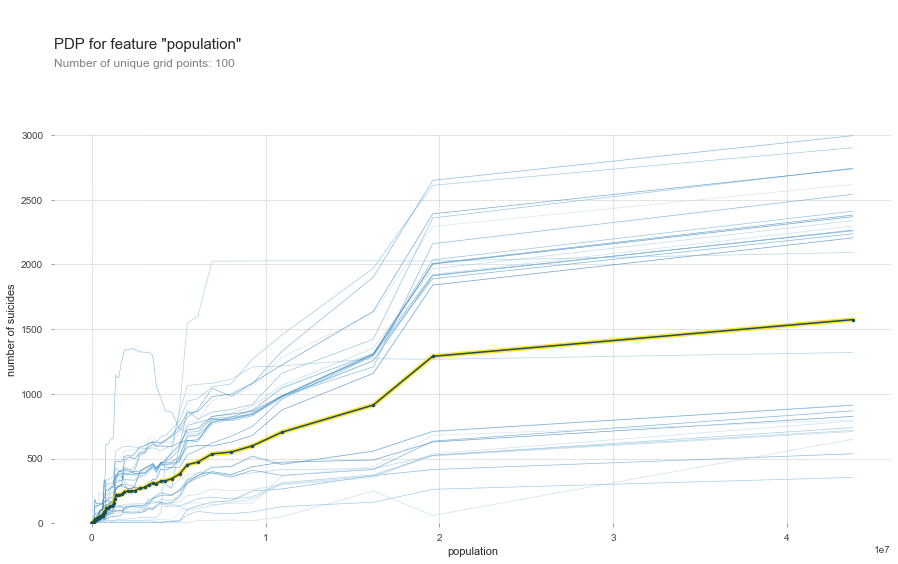

In [58]:
feature='population'

isolated=pdp_isolate(
    model=pipe,
    dataset=X_train,
    model_features=X_train.columns.tolist(),
    feature=feature,
    num_grid_points=100
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=30)
plt.ylabel('number of suicides')
plt.ylim(0,3000)

In [56]:
features=['population', 'age']
interaction=pdp_interact(
    model=pipe,
    dataset=X_train,
    model_features=X_train.columns.tolist(),
    features=features,
)
pdp_interact_plot(interaction, plot_type='grid',feature_names=features)

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
X_train.isna().sum()

In [ ]:
pipe=make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(),
    RandomForestRegressor(n_jobs=-1, n_estimators=100)
)

In [ ]:
search=GridSearchCV(pipe, {'selectkbest__k':range(1,len(cols))},n_jobs=-1,cv=3,verbose=20)

In [ ]:
search.fit(X_train,y_train)

In [ ]:
search.best_params_

In [ ]:
pipe.score(X_test,y_test)

In [ ]:
#nothing below this will run in a reset and run all 
assert True==False

In [ ]:
df.dropna(axis=0,subset=['HDI_for_year']).groupby('country')['HDI_for_year']

In [ ]:
#cleans up the nan's by replacing them with the countrie's average score. 
def HDIcleanup(data):
    country=data[0]
    HDI=data[1]
    if np.isnan(HDI):       
        return countrySer[country]
    else:
        return HDI
df['HDI_for_year']=df[['country','HDI_for_year']].apply(HDIcleanup,axis=1)

In [ ]:
countrySer=df.groupby('country')["HDI_for_year"].mean()

In [ ]:
encoder=ce.OneHotEncoder()
encoder.fit(X_test)

In [ ]:
encoder.transform(X_test).columns.tolist()